In [1]:
import pyshtools
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from scipy.interpolate import RegularGridInterpolator
from scipy.special import sph_harm 

%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/smsharma/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/smsharma/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
nside = 128
ell, m = 2, 1

npix = hp.nside2npix(nside)
lon, lat = (hp.pix2ang(nside, np.arange(npix), lonlat=True))

## First compute with `scipy.special.sph_harm` as usual

In [3]:
npix = hp.nside2npix(nside)
pix_coords = np.asarray(hp.pixelfunc.pix2ang(nside, np.arange(npix))).transpose()

def Y_lm_map_sp(l, m):
    map_ary = np.zeros(npix, dtype=np.complex)
    for i in np.arange(npix):
        map_ary[i] += sph_harm(m, l, pix_coords[i,1], pix_coords[i,0])
    return map_ary


In [4]:
Ylm_map_scipy = Y_lm_map_sp(ell, m)

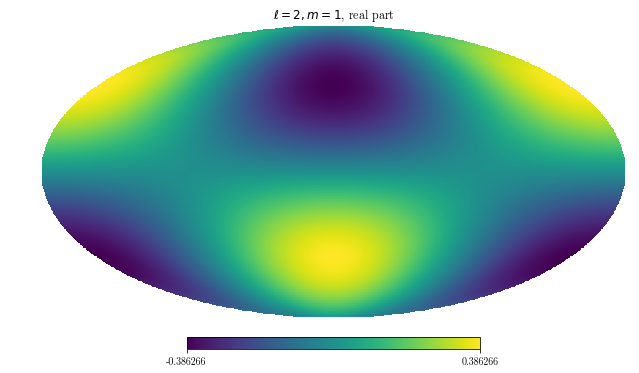

In [5]:
hp.mollview(np.real(Ylm_map_scipy), title="$\ell = {}, m = {}$, real part".format(ell, m))

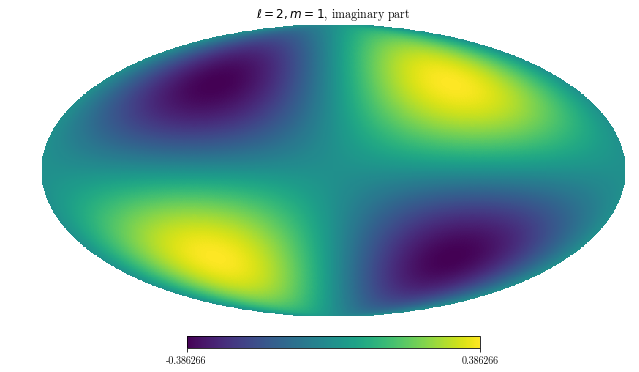

In [6]:
hp.mollview(np.imag(Ylm_map_scipy), title="$\ell = {}, m = {}$, imaginary part".format(ell, m))

## Now compute with `pyshtools`

In [7]:
npix = hp.nside2npix(nside)
lon, lat = (hp.pix2ang(nside, np.arange(npix), lonlat=True))

In [8]:
# lmax set to arbitrary high value to ensure good interpolation
# might need to increase if going to very high multipoles

def Y_lm_map_sh(ell, m, lmax=200):  
    
    ## Calculate real part

    coeffs = np.zeros((2, lmax + 1, lmax + 1))
    coeffs[0, ell, m] = 1

    harmonics = pyshtools.SHCoeffs.from_array(coeffs, normalization='4pi', csphase=-1)
    grid = harmonics.expand(grid='DH2')
    lons = grid.lons()
    lats = grid.lats()
    ylm_interp = grid.to_array()
    rg = RegularGridInterpolator([-lats, lons], ylm_interp, bounds_error=False, fill_value=None)

    # Interpolate to healpix coordinates and normalize
    ylm = rg(np.transpose([-lat, lon])).astype(complex) / (2 * ell + 1)

    ## Calculate imaginary part

    coeffs = np.zeros((2, lmax+1, lmax+1))
    coeffs[1, ell, m] = 1.
    
    harmonics = pyshtools.SHCoeffs.from_array(coeffs, normalization='4pi', csphase=-1)
    grid = harmonics.expand(grid='DH2')
    ylm_interp = grid.to_array()
    rg = RegularGridInterpolator([-lats, lons], ylm_interp, bounds_error=False, fill_value=None)

    # Interpolate to healpix coordinates and normalize, add imaginary part
    ylm += 1.j * (rg(np.transpose([-lat, lon])) / (2 * ell + 1))
    
    return ylm

In [9]:
Ylm_map_sh = Y_lm_map_sh(ell, m)

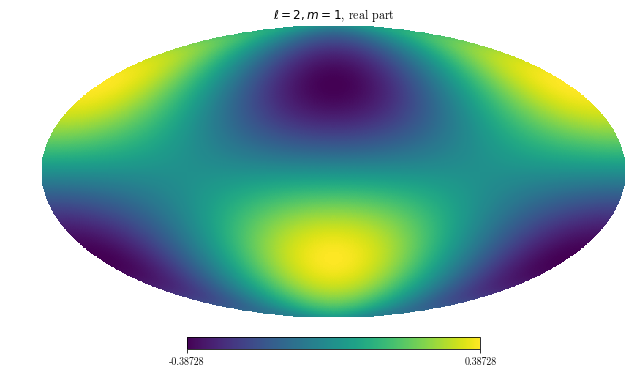

In [10]:
hp.mollview(np.real(Ylm_map_sh), title="$\ell = {}, m = {}$, real part".format(ell, m))

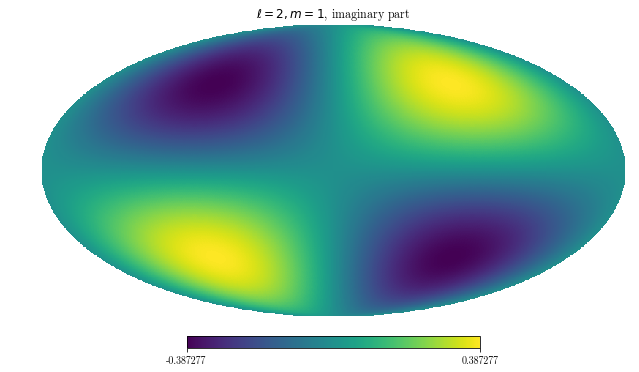

In [11]:
hp.mollview(np.imag(Ylm_map_sh), title="$\ell = {}, m = {}$, imaginary part".format(ell, m))

## Test speed

In [12]:
%%timeit 

# shtools
Y_lm_map_sh(ell, m)

113 ms ± 3.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit 

# scipy
Y_lm_map_sp(ell, m)

1.04 s ± 93.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Test on high multipoles

In [14]:
ell = 200
m = 100

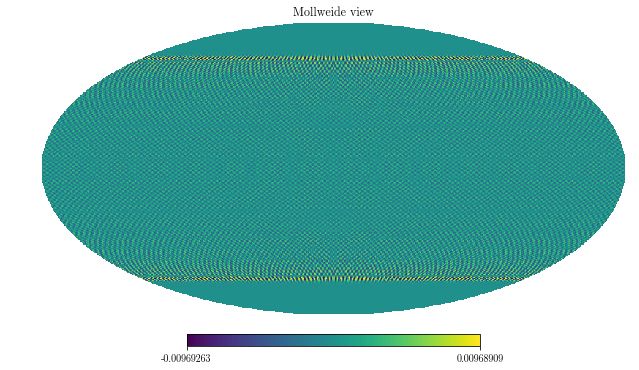

In [15]:
# Good!
hp.mollview(np.real(Y_lm_map_sh(ell, m)))

/Users/smsharma/anaconda3/lib/python3.7/site-packages/healpy-1.12.9-py3.7-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/smsharma/anaconda3/lib/python3.7/site-packages/healpy-1.12.9-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1176: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/Users/smsharma/anaconda3/lib/python3.7/site-packages/healpy-1.12.9-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1177: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


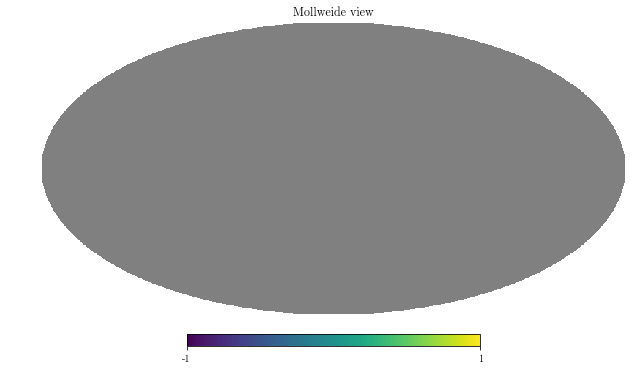

In [16]:
# Craps out
hp.mollview(np.real(Y_lm_map_sp(ell, m)))